In [173]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [174]:
file_path = 'Data assignment 1/Feature data.csv'
data = pd.read_csv(file_path)

### Feature scaling

In this step,we used Principal Component Analysis (PCA) to select and reduce the dimensionality of the features.

In [175]:
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

### 1. Standard Scaling for wind speed and temperature
data['Mean wind speed'] = scaler_standard.fit_transform(data[['Mean wind speed']])
data['Maximum temperature'] = scaler_standard.fit_transform(data[['Maximum temperature']])

### 2. Wind Direction (convert to sin and cos components)
data['Wind direction sin'] = np.sin(np.deg2rad(data['Mean wind direction']))
data['Wind direction cos'] = np.cos(np.deg2rad(data['Mean wind direction']))

### 3. Normalize Power Production 
nominal_capacity = 30000 # production capacity is 30 MW, unit of power production is kW so nominal capacity is 30000
data['AKI Kalby Active Power'] = data['AKI Kalby Active Power'] / nominal_capacity

# Dropping the original wind direction after transformation
data = data.drop('Mean wind direction', axis=1)

In [176]:
# Make sure datetime is set as the index
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

In [177]:
# set target and features, and remove non-numeric columns
target_column = 'AKI Kalby Active Power'
features = data.select_dtypes(include=[np.number]).drop(columns=[target_column])

In [178]:
data

,AKI Kalby Active Power,Maximum temperature,Mean wind speed,Wind direction sin,Wind direction cos
datetime,,,,,
2022-01-01 00:00:00,-0.063118,-0.457945,0.868655,-0.998630,-5.233596e-02
2022-01-01 01:00:00,-0.055728,-0.457945,0.382418,-0.956305,-2.923717e-01
2022-01-01 02:00:00,-0.095724,-0.503187,0.756447,-0.994522,-1.045285e-01
2022-01-01 03:00:00,-0.063726,-0.518268,0.494627,-1.000000,-1.836970e-16
2022-01-01 04:00:00,-0.029392,-0.473025,0.307612,-0.951057,3.090170e-01
...,...,...,...,...,...
2022-12-31 19:00:00,-0.148665,0.009559,1.953338,-0.656059,-7.547096e-01
2022-12-31 20:00:00,-0.153192,0.039721,1.467101,-0.731354,-6.819984e-01
2022-12-31 21:00:00,-0.120257,0.039721,1.504504,-0.681998,-7.313537e-01


In [179]:
# split the data
X = data.drop(columns=[target_column])
y = data[target_column]

split_data= TimeSeriesSplit(n_splits=3, test_size=int(0.2*len(data)))
for train_index, test_index in split_data.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print("TRAIN indices:", train_index, "TEST indices:", test_index)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

TRAIN indices: [   0    1    2 ... 6248 6249 6250] TEST indices: [6251 6252 6253 ... 7810 7811 7812]
X_train shape: (6251, 4)
X_test shape: (1562, 4)
y_train shape: (6251,)
y_test shape: (1562,)


### Step 3 Linear regression

In [180]:
# Step 3.1 Please show that these two methods end up with the same solution.
X_sample = features[:100]
y_sample = data[target_column][:100]

In [181]:
# Sequential split (shuffle=False)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, shuffle=False, random_state=42)

# Adding a column of ones to X_sample for the bias term and converting to NumPy array
X_sample_train_with_bias = np.c_[np.ones(X_sample_train.shape[0]), X_sample_train].astype(float)
X_sample_test_with_bias = np.c_[np.ones(X_sample_test.shape[0]), X_sample_test].astype(float)

# Ensure y_sample_train is also a NumPy array
y_sample_train = np.array(y_sample_train).astype(float)

In [182]:
# Gradient Descent function
def gradient_descent(X, y, learning_rate=0.01, epochs=100000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(epochs):
        y_pred = X @ theta
        gradients = (1/m) * X.T @ (y_pred - y)
        theta -= learning_rate * gradients
    return theta

theta_gd = gradient_descent(X_sample_train_with_bias, y_sample_train)

# Predictions using Gradient Descent
y_pred_gd = X_sample_test_with_bias @ theta_gd

In [183]:
# Closed-form solution 
theta_closed_form = np.linalg.inv(X_sample_train_with_bias.T @ X_sample_train_with_bias) @ X_sample_train_with_bias.T @ y_sample_train

# Predictions using closed-form solution
y_pred_closed_form = X_sample_test_with_bias @ theta_closed_form

In [184]:
# mse calculation
mse_gd = mean_squared_error(y_sample_test, y_pred_gd)
mse_closed_form = mean_squared_error(y_sample_test, y_pred_closed_form)

print(f"Gradient Descent θ: {[f'{x:.5f}' for x in theta_gd]}")
print(f"Closed-Form θ: {[f'{x:.5f}' for x in theta_closed_form]}")
print(f"Gradient Descent MSE: {mse_gd:.5f}")
print(f"Closed-Form MSE: {mse_closed_form:.5f}")

Gradient Descent θ: ['-0.03789', '0.02592', '-0.04119', '0.01152', '0.01116']
Closed-Form θ: ['-0.03789', '0.02592', '-0.04119', '0.01152', '0.01116']
Gradient Descent MSE: 0.00099
Closed-Form MSE: 0.00099


In [185]:
# Step 3.2: Use the full dataset and closed form solution
X_large_sample, X_large_test_sample, y_large_sample, y_large_test_sample = train_test_split(features, data[target_column], test_size=0.2, random_state=42)

# Adding a column of ones for the bias term in the large sample
X_large_sample_with_bias = np.c_[np.ones(X_large_sample.shape[0]), X_large_sample]
X_large_test_sample_with_bias = np.c_[np.ones(X_large_test_sample.shape[0]), X_large_test_sample]

# Upgrade the normal equation
theta_large_sample = np.linalg.inv(X_large_sample_with_bias.T @ X_large_sample_with_bias) @ X_large_sample_with_bias.T @ y_large_sample
theta_large_sample_rounded = np.round(theta_large_sample, 5)

print(f"Step 3.2: Closed-form solution training complete on the larger sample.")
print(f"Coefficients: {[f'{x:.5f}' for x in theta_large_sample_rounded]}")

Step 3.2: Closed-form solution training complete on the larger sample.
Coefficients: ['-0.04394', '0.00016', '-0.03909', '0.00591', '0.00366']


In [186]:
# Step 3.3: Verify your model using the testing dataset and appropriate evaluation metrics
y_large_pred_closed_form = X_large_test_sample_with_bias @ theta_large_sample

mse = mean_squared_error(y_large_test_sample, y_large_pred_closed_form)
mae = mean_absolute_error(y_large_test_sample, y_large_pred_closed_form)
r2 = r2_score(y_large_test_sample, y_large_pred_closed_form)
rmse = np.sqrt(mse)

print(f"Step 3.3: Model evaluation on the testing dataset:")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R-squared: {r2:.5f}")

Step 3.3: Model evaluation on the testing dataset:
Root Mean Squared Error (RMSE): 0.03016
Mean Squared Error (MSE): 0.00091
Mean Absolute Error (MAE): 0.02294
R-squared: 0.64752


### Step 4 Non-linear Regression

In Step 1's formulation, if the price $\lambda$ is treated as a constant and the actual value p is known, the entire formula simplifies into a function dependent on the predicted value $\hat{p}_t$. This implies that the problem can be reframed as an optimization task concerning the prediction of $\hat{p}_t$. Given this perspective, extending the linear regression model from Step 3 by incorporating nonlinear features to predict $\hat{p}_t$ effectively transforms the problem into a nonlinear regression for Step 1's objective. Therefore, performing nonlinear regression on the prediction model of $\hat{p}_t$ inherently satisfies the requirements of the nonlinear extension outlined in Step 4.

In [187]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [188]:
# Step 4.1: Add polynomial features (squared and cubic terms)
poly = PolynomialFeatures(degree=3, include_bias=False) 
X_poly = poly.fit_transform(features)

# Convert to DataFrame with correct column names
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(features.columns))

# Split the polynomial feature data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly_df, data[target_column], test_size=0.2, random_state=42)

# Fit linear regression model on the polynomial features
linear_model_poly = LinearRegression()
linear_model_poly.fit(X_train_poly, y_train_poly)

# Predict on the testing data
y_pred_poly = linear_model_poly.predict(X_test_poly)

In [189]:
# evaluate the performance
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f"Nonlinear model evaluation on the testing dataset:")
print(f"Root Mean Squared Error (RMSE): {rmse_poly:.4f}")
print(f"Mean Squared Error (MSE): {mse_poly:.4f}")
print(f"Mean Absolute Error (MAE): {mae_poly:.4f}")
print(f"R-squared: {r2_poly:.4f}")

Nonlinear model evaluation on the testing dataset:
Root Mean Squared Error (RMSE): 0.0278
Mean Squared Error (MSE): 0.0008
Mean Absolute Error (MAE): 0.0204
R-squared: 0.7015


For step 4.2, the method of locally weighted least squares will be used, as tought in the lecture. Different kernels will be compared and the best one will be chosen based on evaluating the performance on the test data.

In [190]:
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return res

def tricube(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return res

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return res

In [191]:
# Locally Weighted Least Squares implementation
def lwls_predict(X_train, y_train, X_test, kernel_func, tau=0.1):
    y_pred = np.zeros(len(X_test))

    for i, x in enumerate(X_test):
        distances = np.linalg.norm(X_train - x, axis=1)  # Compute distances
        weights = kernel_func(distances / tau)  # Apply kernel function
        W = np.diag(weights)  # Create diagonal weight matrix

        # Weighted Least Squares computation
        XTWX = X_train.T @ W @ X_train  # X^T W X
        XTWy = X_train.T @ W @ y_train  # X^T W y

        # Use np.linalg.pinv for numerical stability
        theta = np.linalg.pinv(XTWX) @ XTWy

        # Ensure x is 2D before matrix multiplication
        y_pred[i] = np.dot(x, theta)  # Prediction for the current test sample

    return y_pred

In [192]:
# Function to evaluate different kernels and select the best one
def evaluate_kernels(X_train, y_train, X_test, y_test, kernels, tau=0.1):
    mse_results = {}

    for kernel_name, kernel_func in kernels.items():

        y_pred = lwls_predict(X_train, y_train, X_test, kernel_func, tau=tau)
        mse = mean_squared_error(y_test, y_pred)
        mse_results[kernel_name] = mse

    return mse_results

# Example kernels (ensure these are defined somewhere in the code)
kernels = {
    'Gaussian': gaussian,
    'Epanechnikov': epanechnikov,
    'Tricube': tricube,
    'Uniform': uniform,
    'Triangle': triangle
}

In [193]:
# Evaluate kernels on smaller data for faster results
mse_results_small = evaluate_kernels(X_sample_train_with_bias, y_sample_train, X_sample_test_with_bias, y_sample_test, kernels)

print(mse_results_small)

{'Gaussian': 0.017111643456072034, 'Epanechnikov': 0.015838563409984314, 'Tricube': 0.015838563409984314, 'Uniform': 0.0009889360972607534, 'Triangle': 0.015838563409984314}


In [ ]:
# Evaluation on the kernel selected
def evaluate_uniform(X_train, y_train, X_test, y_test, uniform, tau=0.1):
    for kernel_name, kernel_func in uniform.items():
        y_pred = lwls_predict(X_train, y_train, X_test, kernel_func, tau=tau)
        
        mse = mean_squared_error(y_test, y_pred)
        mae_wls_uniform = mean_absolute_error(y_test, y_pred)
        r2_wls_uniform = r2_score(y_test, y_pred)
        rmse_wls_uniform = np.sqrt(mse)
        
        print(f"{kernel_name} Kernel Results:")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae_wls_uniform}")
        print(f"R-squared (R2): {r2_wls_uniform}")
        print(f"Root Mean Squared Error (RMSE): {rmse_wls_uniform}")

    return

uniform_kernel = {
    'Uniform': uniform
}

evaluate_uniform(X_large_sample_with_bias, y_large_sample, X_large_test_sample_with_bias, y_large_test_sample, uniform_kernel)

### Step 5 Regularization
#### Lasso regularization
##### linear regression
In order to apply lasso regression there are two prerequisites.  the linear regression has to be performed and the Gradient Descent has to be calculated. 
The gradient descent is used to update the coefficients iteratively through training instances 

In [95]:
class LassoRegression():
    def __init__(self, learning_rate, iterations, l1_penalty):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l1_penalty = l1_penalty
        
    def fit(self, X, Y):
        self.m, self.n = X.shape
        # set the original weights
        self.W = np.zeros(self.n)
        # set the bias term
        self.b = 0 
        # X matrix
        self.X = X
        # Y vector
        self.Y = Y
        for i in range(self.iterations):
            self.update_weights()
        return self
    
    def update_weights(self):
        Y_pred = self.predict(self.X)
        dW = np.zeros(self.n)
        for j in range(self.n):
            if self.W[j]>0:
                dW[j] = (-2*(self.X[:,j]).dot(self.Y-Y_pred)+self.l1_penalty)/self.m
            else:
                dW[j] = (-2*(self.X[:,j]).dot(self.Y-Y_pred)-self.l1_penalty)/self.m
                
        db = -2*np.sum(self.Y-Y_pred)/self.m
        
        # update weights
        self.W = self.W-self.learning_rate*dW
        # update bias
        self.b = self.b - self.learning_rate*db
        return self
    
    def predict(self,X):
        return np.dot(X, self.W)+self.b 
            

ValueError: x and y must be the same size

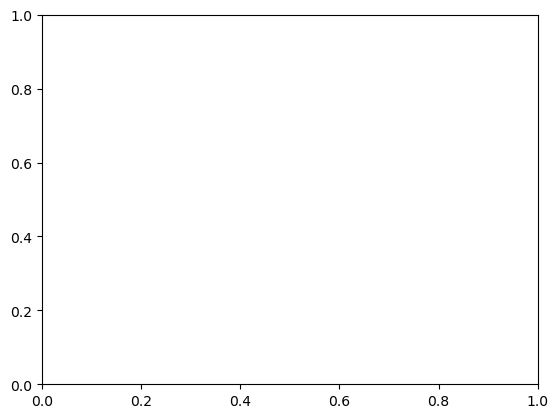

In [96]:
lasso_model=LassoRegression(learning_rate=0.01, iterations=10000, l1_penalty=0.1)
lasso_model.fit(X_large_sample_with_bias,y_large_sample)
y_pred_lasso = lasso_model.predict(X_large_test_sample_with_bias)

plt.scatter(X_large_test_sample, y_large_sample, color='blue', label='Actual Data')
plt.plot(X_large_test_sample_with_bias, y_pred_lasso, color='green', label='Lasso regression')
plt.plot(X_large_test_sample_with_bias, y_pred_gd, color='orange', label='Linear regression')
plt.title('Linear vs Lasso regression')
plt.xlabel('Time')
plt.ylabel('Active power production')
plt.legend()
plt.show()